In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

In [2]:
data = pd.read_csv('data/runs/n_results.csv', index_col='run')
drug_data = pd.read_csv('full_drug_new.csv')
#drug_data = pd.read_csv('data/runs/drug_data.csv')

# Data cleaning

In [3]:
data = data[data['status']=='completed']
data = data[data['r_2_mean'].notnull()]

data['time'] = pd.to_timedelta(data['time'])
data['started'] = pd.to_datetime(data['started'])
data['seconds'] = data['time'].apply(lambda x:x.seconds)

data['datasets'] = data['gdsc']+data['ctrp']+data['ccle']
data = data[data['datasets']>0]

# The only valid daata
ndata = data[data['started'] > pd.to_datetime('2020-04-15 18:00:00')]

# Joint drug data
drug_data_j = drug_data.join(ndata, rsuffix='_drug', on='run')
drug_data_j = drug_data_j[drug_data_j['started'].notnull()]
ndrug_data = drug_data_j[drug_data_j['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full_data = drug_data.join(data, on='run', rsuffix='_drug')

In [4]:
ndata.describe()

,time,ajive,cutoff,drugs,n,test,threshold,step,r_2_mean,r_2_std,seconds
count,5341,3253.000000,5341.0,5341.000000,5341.000000,0.0,5.341000e+03,5341.0,5341.000000,5340.000000,5341.000000
mean,0 days 00:57:58.619546,2.010144,4.0,19.996443,0.098207,NaN,1.000000e-02,0.0,0.033973,0.344469,3316.852088
std,0 days 01:59:43.764923,0.812848,0.0,0.259981,0.056780,NaN,1.734886e-18,0.0,1.889137,8.390248,5695.418557
min,0 days 00:00:33,1.000000,4.0,1.000000,0.000853,NaN,1.000000e-02,0.0,-136.615707,0.000876,33.000000
25%,0 days 00:09:18,1.000000,4.0,20.000000,0.048426,NaN,1.000000e-02,0.0,-0.031964,0.097725,558.000000
50%,0 days 00:29:49,2.000000,4.0,20.000000,0.097511,NaN,1.000000e-02,0.0,0.086542,0.132590,1789.000000
75%,0 days 01:03:43,3.000000,4.0,20.000000,0.146495,NaN,1.000000e-02,0.0,0.176236,0.204099,3823.000000
max,1 days 17:43:37,3.000000,4.0,20.000000,0.199802,NaN,1.000000e-02,0.0,0.432360,609.875488,82747.000000


# IC/EC quality effect on r2

In [48]:
drugs = drug_data.groupby('Drug').agg({'r2_score': ['mean', 'std']})
drugs['runs'] = [drug_data[drug_data['Drug']==i].shape[0] for i in drugs.index]
one = drugs[drugs['runs']<50].sort_values(by=('r2_score', 'mean'), ascending=False)
multiple = drugs[drugs['runs']>50].sort_values(by=('r2_score', 'mean'), ascending=False)

In [7]:
ctrp = pd.read_csv('data/Processed/ctrp_poz_dr.csv')
gdsc = pd.read_csv('data/Processed/gdsc_poz_dr.csv')
ccle = pd.read_csv('data/Processed/ccle_poz_dr.csv')

In [8]:
scoring = {'Low':-1, 'Medium':0, 'High':1}
ctrp['IC'] = ctrp['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)
gdsc['IC'] = gdsc['IC50_quality'].replace(scoring)

ctrp['EC'] = ctrp['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)
gdsc['EC'] = gdsc['EC50_quality'].replace(scoring)

In [21]:
dr = pd.concat([ctrp, gdsc, ccle], sort=True)

In [9]:
c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [132]:
#c_dict = pd.concat([ctrp, gdsc, ccle], sort=True).groupby('Drug_name').mean()[['IC', 'EC', 'IC50_residual_standard_error', 'EC50_residual_standard_error']]

In [11]:
full = drug_data.join(data, on='run', rsuffix='_drug')
full['Quality'] = [c_dict.loc[full.loc[i]['Drug']]['IC'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC'] for i in full.index]
#full['Error'] = [c_dict.loc[full.loc[i]['Drug']]['IC50_residual_standard_error'] if full.loc[i]['metric_drug']=='AUC_IC50' else c_dict.loc[full.loc[i]['Drug']]['EC50_residual_standard_error'] for i in full.index]

In [12]:
full['Quality'] = full['Quality'].fillna(-1)

In [13]:
#full.to_csv('data/runs/full.csv',index=False)

In [14]:
#sns.relplot(x='Error', y='r2_score', data=full[full['r2_score']>-20], kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)

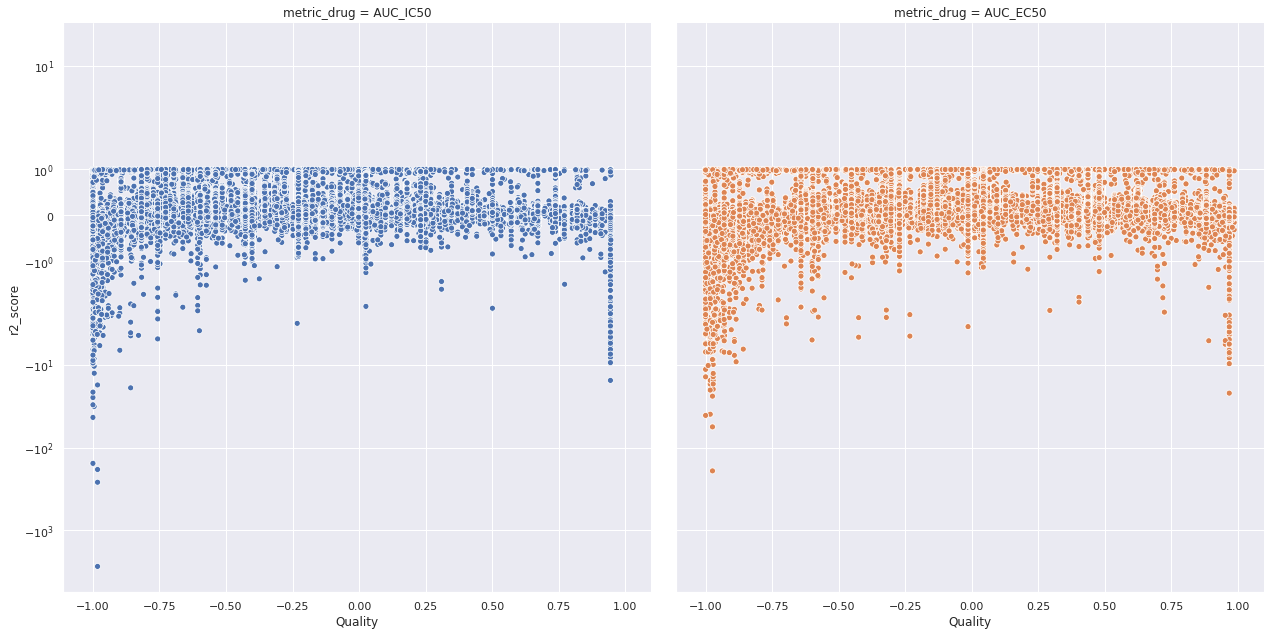

In [189]:
sns.set()
g = sns.relplot(x='Quality', y='r2_score', data=full, kind='scatter', height=9, col='metric_drug', hue='metric_drug', legend=False)
g.set(yscale='symlog')
#plt.savefig('IC quality vs r2.png')

In [17]:
drug_ic = full.groupby('Drug').mean()

In [22]:
drug_ic['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in drug_ic.index]

<Figure size 432x288 with 0 Axes>

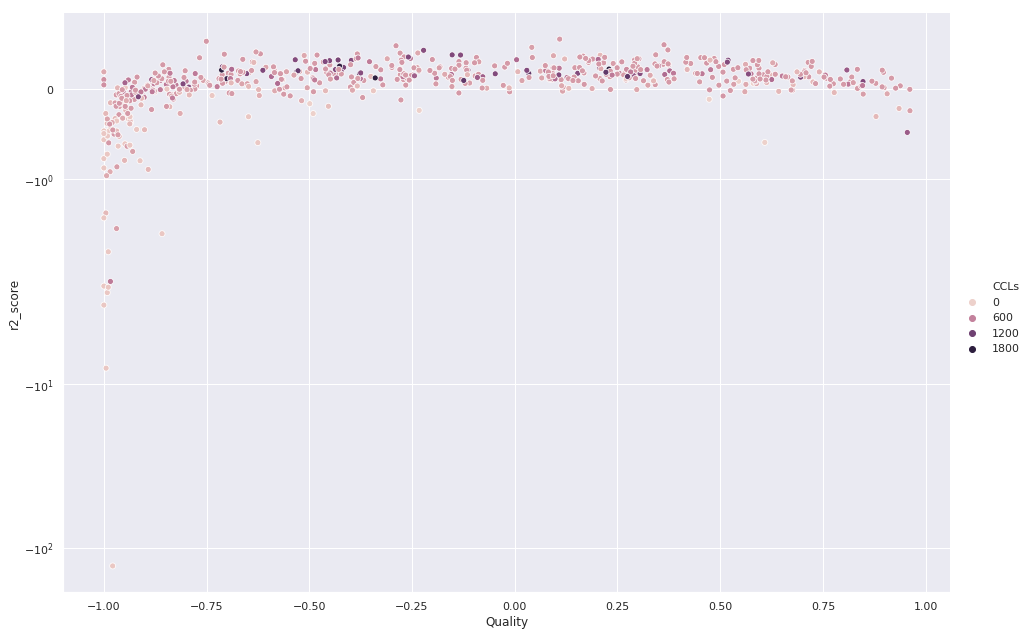

In [188]:

g = sns.relplot(x='Quality', y='r2_score', data=drug_ic, hue='CCLs', kind='scatter', height=9, aspect=1.5)
g.set(yscale='symlog')

#plt.legend(loc = 'lower right')
#plt.savefig('IC quality vs r2.png')

## A threshold of -0.75 IC quality is set 
All runs below that are disregarded

In [25]:
clean = full[full['Quality']>-0.75]

In [36]:
clean = clean[clean['started'] > pd.to_datetime('2020-04-15 18:00:00')]

In [37]:
full.shape

(133632, 74)

In [38]:
clean.shape

(81301, 74)

# Per model

In [39]:
nmodels = clean.groupby('model').median()
nmodels['Number of runs'] = [clean[(clean['model']==i) & (clean['started'] > pd.to_datetime('2020-04-15 18:00:00'))].shape[0] for i in nmodels.index]
nmodels[['r2_score', 'r_2_std']]

,r2_score,r_2_std
model,,
DecisionTreeRegressor,-0.017046,0.195729
ElasticNet,0.093935,0.097843
KNeighborsRegressor,0.104238,0.117305
RandomForestRegressor,0.115643,0.117045
SVR,0.100237,0.214548


# AJIVE analysis

In [40]:
many = clean[clean['datasets']>1]
many.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,46164.000000,46164.000000,46164.000000
mean,0.104573,0.129907,4438.975479
std,0.147335,0.115343,6345.421558
min,-0.387880,0.000876,58.000000
25%,-0.010301,0.054506,847.000000
50%,0.097609,0.114628,2820.000000
75%,0.235686,0.184051,5333.000000
max,0.432360,1.608504,70690.000000


In [41]:
ajive = clean[(clean['ajive'].notnull())& (clean['datasets']>1)]
ajive.describe()[['r_2_mean', 'r_2_std', 'seconds']]

,r_2_mean,r_2_std,seconds
count,14783.000000,14783.000000,14783.000000
mean,0.160139,0.169731,3711.378002
std,0.123742,0.106659,6049.571043
min,-0.387880,0.011713,58.000000
25%,0.086991,0.105944,742.000000
50%,0.178575,0.146924,2330.000000
75%,0.249746,0.210757,4243.000000
max,0.432360,1.608504,70690.000000


# Hard to predict drugs

In [42]:
ctrp_low = ctrp[ctrp['IC50_quality']=='Low']['Drug_name'].unique()
gdsc_low = gdsc[gdsc['IC50_quality']=='Low']['Drug_name'].unique()
ccle_low = ccle[ccle['IC50_quality']=='Low']['Drug_name'].unique()

In [43]:
#low_ic = np.concatenate([ctrp_low, gdsc_low, ccle_low])

In [44]:
ic_dict = pd.concat([ctrp, gdsc, ccle]).groupby('Drug_name').mean()[['IC']]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [49]:
one['IC'] = [ic_dict.loc[i]['IC'] for i in one.index]
one['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in one.index]

In [50]:
multiple['IC'] = [ic_dict.loc[i]['IC'] for i in multiple.index]
multiple['CCLs'] = [dr[dr['Drug_name']==i].shape[0] for i in multiple.index]

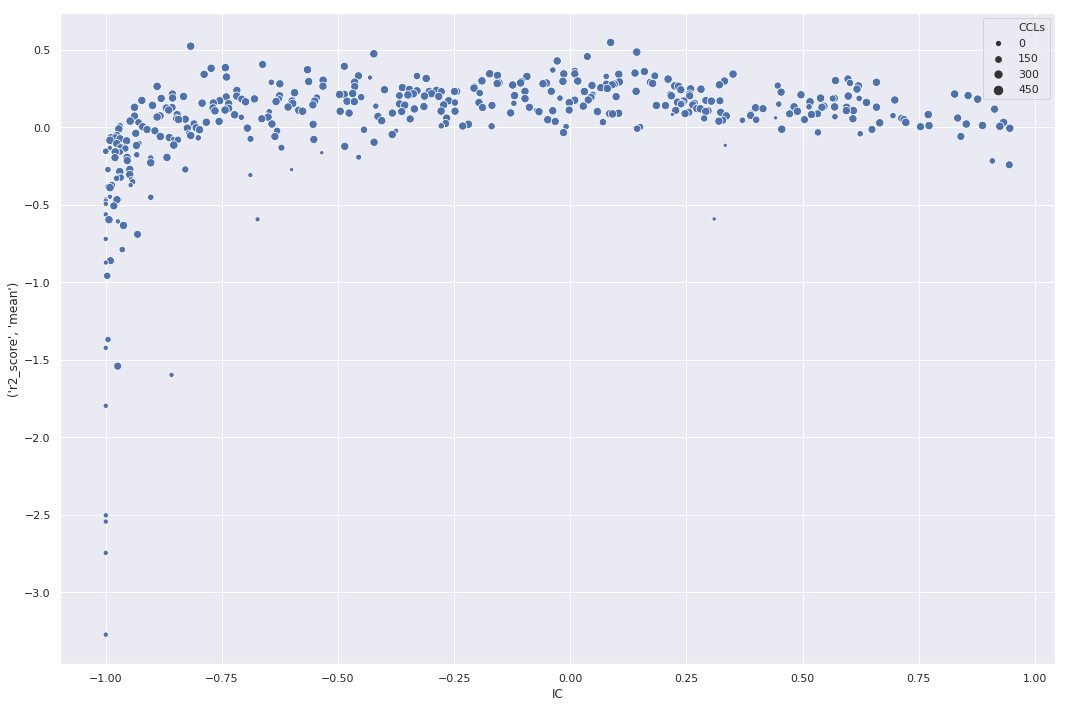

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='IC', y=('r2_score', 'mean'), size='CCLs', data=one[one['r2_score']['mean']>-20], ax=ax)
plt.tight_layout()
#plt.savefig('IC quality vs r2.png')

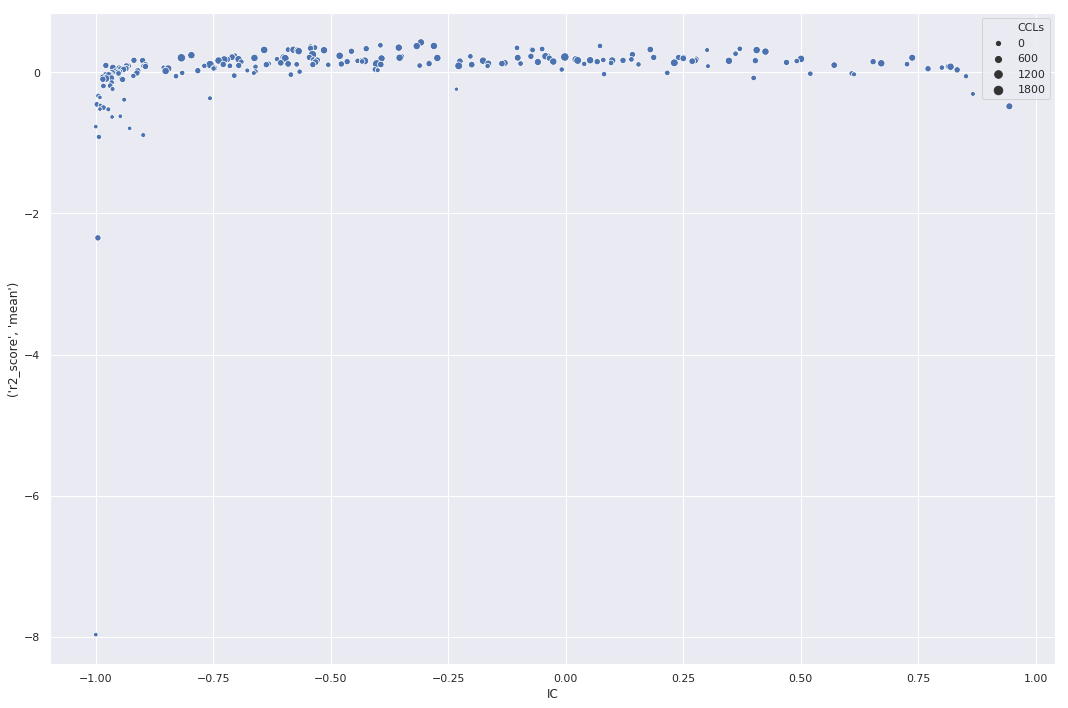

In [52]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x='IC', y=('r2_score', 'mean'), size='CCLs', data=multiple[multiple['r2_score']['mean']>-20], ax=ax)
plt.tight_layout()

In [53]:
drugs.sort_values(('r2_score', 'mean')).head()

r2_score             runs
                     mean         std     
Drug                                      
BRD-K13185470 -129.589152  488.806251   31
BRD-K27986637   -7.967519   28.643415   60
BRD-K44224150   -3.274224    7.224934   39
BRD-K78574327   -2.746796    4.450761   34
ML312           -2.544982    7.871729   49

In [54]:
outliers = pd.DataFrame(columns=['ctrp', 'datasets', 'r2_score'])
for i in drugs[drugs['runs']<50].index:
    dr = drug_data_j[drug_data_j['Drug']==i]
    
    outliers.loc[i] = [dr['ctrp'].mean(), dr['datasets'].mean(), dr['r2_score'].mean()]

In [55]:
outliers.describe()

,ctrp,datasets,r2_score
count,400.0,400.0,400.000000
mean,1.0,1.0,-0.426818
std,0.0,0.0,7.342537
min,1.0,1.0,-146.725947
25%,1.0,1.0,-0.099380
50%,1.0,1.0,0.007636
75%,1.0,1.0,0.097420
max,1.0,1.0,0.441915


In [56]:
one.describe()

r2_score                    runs          IC        CCLs
             mean         std                                    
count  400.000000  400.000000  400.000000  400.000000  400.000000
mean    -0.302478    1.665902   37.457500   -0.265656  367.675000
std      6.493200   24.428444    6.903792    0.569189  103.310464
min   -129.589152    0.053229   16.000000   -1.000000   39.000000
25%     -0.016140    0.236596   33.000000   -0.822031  369.250000
50%      0.108657    0.301589   38.000000   -0.322631  419.000000
75%      0.209991    0.381166   43.000000    0.217922  430.000000
max      0.546171  488.806251   49.000000    0.945882  447.000000

In [57]:
multiple.describe()

r2_score                     runs          IC         CCLs
             mean         std                                      
count  215.000000  215.000000   215.000000  211.000000   215.000000
mean     0.023356    0.529338   549.065116   -0.373494   646.753488
std      0.615482    1.971272  1060.405960    0.530954   334.568225
min     -7.967519    0.089279    51.000000   -1.000000    43.000000
25%      0.011233    0.272445    59.000000   -0.853444   408.000000
50%      0.118297    0.305118   160.000000   -0.528701   658.000000
75%      0.192849    0.352786   540.000000    0.009977   824.000000
max      0.423024   28.643415  4634.000000    0.944186  1598.000000

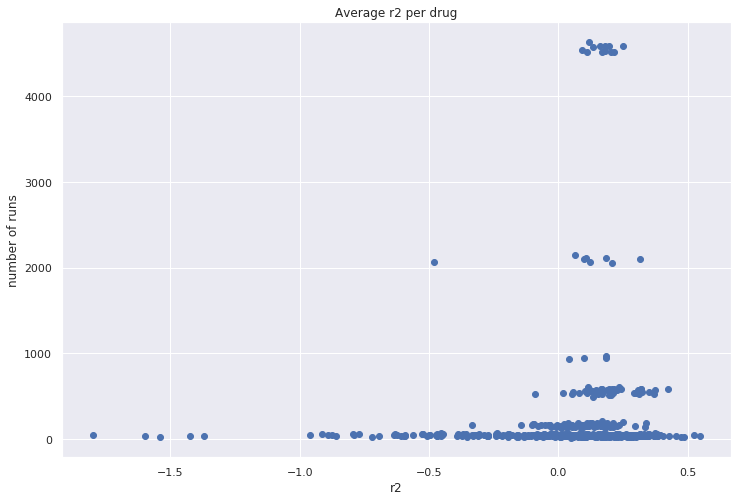

In [58]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(drugs[drugs['r2_score']['mean']>-2]['r2_score']['mean'], drugs[drugs['r2_score']['mean']>-2]['runs'])
ax.set_xlabel('r2')
ax.set_ylabel('number of runs')
ax.set_title('Average r2 per drug')
#plt.savefig('Drug r2.png')

In [ ]:
low = drug_data_j[drug_data_j['Drug'].isin(one.index)]
high = drug_data_j[drug_data_j['Drug'].isin(multiple.index)]

In [68]:
# sns.set(font_scale=1)
# drugs = drug_ic[drug_ic['Quality']>-0.75].reset_index()
# g = sns.catplot(x= 'Drug', y='r2_score',data=drugs, kind='box', height=10, aspect=1.5)
# sns.swarmplot(x= 'Drug', y='r2_score',data=drugs, color='.25')
# g.set_xticklabels(rotation=45)
# plt.tight_layout()
# #plt.savefig('top drugs.png')

# Best performing models on hardest drugs

In [ ]:
split = pd.concat([low, high], keys=['hard', 'easy']).reset_index().rename(columns={'level_0':'type'}).drop('level_1', axis=1)

In [ ]:
hard = low.groupby(['model', 'fs']).mean()[['r2_score', 'r_2_std']].reset_index()

In [ ]:
easy = high.groupby(['model', 'fs']).mean()[['r2_score', 'r_2_std']].reset_index()

In [ ]:
split = pd.concat([easy, hard], keys=['easy', 'hard']).reset_index().rename(columns={'level_0':'type'}).drop('level_1', axis=1)

In [ ]:
sns.set(font_scale=1)

g = sns.catplot(x='fs', y='r2_score', hue='type', data=split[split['r2_score']>-4], kind='boxen', height=10, aspect=1.5, legend=False)
#sns.swarmplot(x='fs', y='r2_score', hue='type',dodge=False, data=split[split['r2_score']>-4], ax=g.ax)
g.set_xticklabels(rotation=45)
g.fig.suptitle('Differences in feature selection performance between easy and hard drugs')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.legend(loc='lower left')
#plt.savefig('FS type of drug.png', bbox_inches='tight')


In [ ]:
g = sns.catplot(x='model', y='r2_score', hue='type', data=split[split['r2_score']>-25], kind='boxen', height=10, aspect=1.5, legend=False)
#sns.swarmplot(x='model', y='r2_score', hue='type',dodge=True, data=split[split['r2_score']>-4], ax=g.ax)
g.set_xticklabels(rotation=45)
g.fig.suptitle('Differences in model performance between easy and hard drugs')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.legend(loc = 'lower left')
#plt.savefig('Model type of drug.png')

# AJIVE rank vs r2

In [70]:
clean['ajive'] = clean['ajive'].fillna(0)

In [77]:
clean.describe()['r2_score']

count    81301.000000
mean         0.081035
std          0.315003
min        -21.885501
25%         -0.013669
50%          0.069669
75%          0.202041
max          0.930501
Name: r2_score, dtype: float64

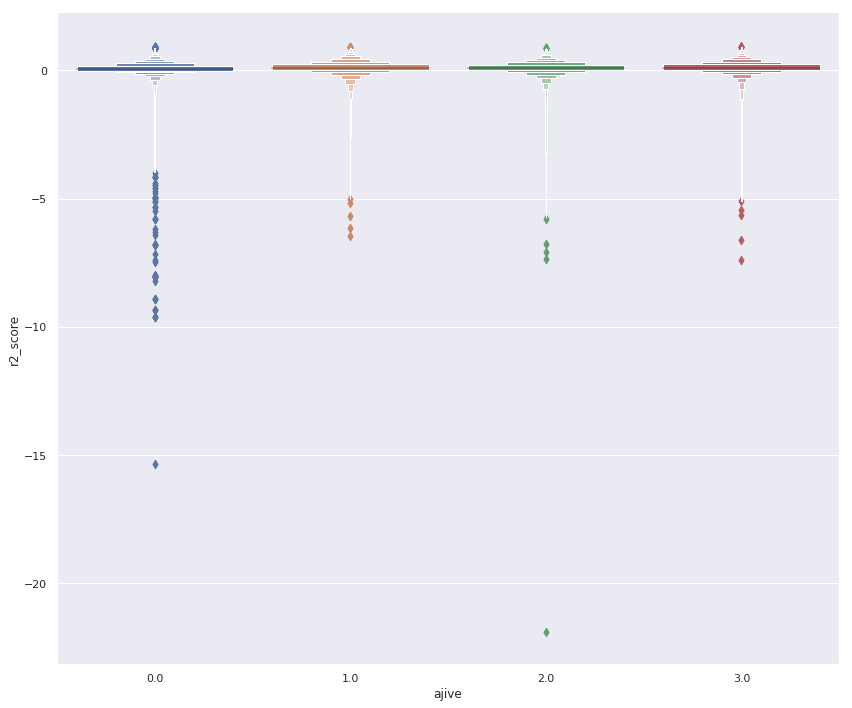

In [75]:
sns.set(font_scale=1)
sns.catplot(x='ajive', y='r2_score', data=clean, kind='boxen', height=10, aspect=1.2)


# Norm

In [ ]:
clean['norm']

In [149]:
clean['norm'] = clean['norm'].fillna('None')

In [153]:
clean.groupby('norm').mean()[['r2_score', 'r_2_std']]

,r2_score,r_2_std
norm,,
MaxAbsScaler,0.095066,0.190755
MinMaxScaler,0.096794,0.268262
None,0.066527,0.255559
QuantileTransformer,0.111652,0.191682
StandardScaler,0.071957,1.012583


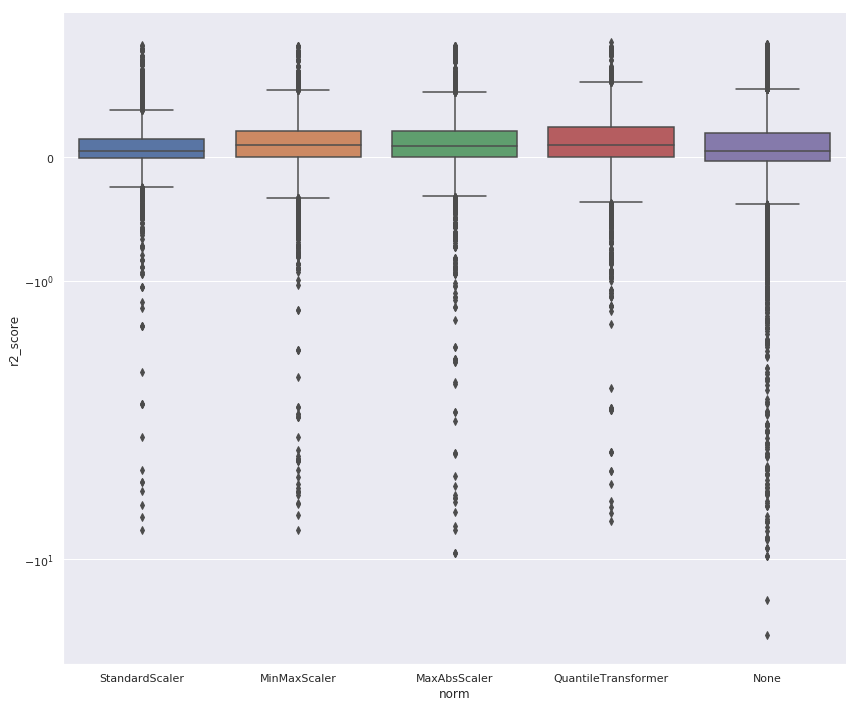

In [190]:
sns.set(font_scale=1)
g = sns.catplot(x='norm', y='r2_score', data=clean, kind='box', height=10, aspect=1.2)
g.set(yscale='symlog')

# DA

In [173]:
#data = drug_data.join(ndata, on='run', rsuffix='drug')
ajive = clean[clean['ajive'].isin([1,2,3])]
feda = clean[clean['feda']==True]
neither = clean[(clean['feda']==False) & (clean['ajive']==0)]

In [174]:
da = pd.concat([ajive, feda, neither], keys=['ajive', 'feda', 'neither']).reset_index()

In [175]:
da.drop('level_1', axis=1).groupby(('model', 'level_0')).mean()[['r2_score', 'r_2_std', 'seconds']]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


r2_score   r_2_std       seconds
model                 level_0                                  
DecisionTreeRegressor ajive    0.009638  0.274591   1629.336634
                      feda    -0.109342  0.204633   2560.746196
                      neither  0.009380  0.288123   1475.962192
ElasticNet            ajive    0.166026  0.114362   2063.858218
                      feda     0.047267  0.059556   3113.207394
                      neither  0.169518  0.132094   1945.414262
KNeighborsRegressor   ajive    0.189389  0.148530   8167.688257
                      feda     0.031591  0.073764  12316.517384
                      neither  0.175801  0.138362   8657.892097
RandomForestRegressor ajive    0.171347  0.165422   2981.289511
                      feda     0.053924  0.075806   5385.704890
                      neither  0.199255  0.148622   3456.649346
SVR                   ajive    0.105641  3.686788   5865.266064
                      feda    -0.028863  0.597449   2543.032969
                      neither  0.136378  0.557924   2181.167970

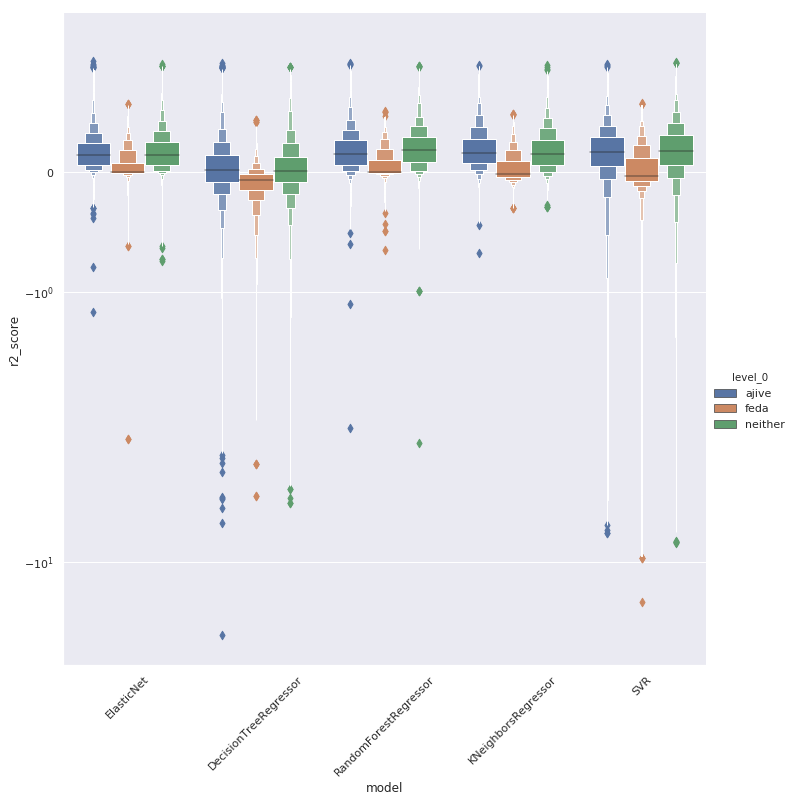

In [191]:
g = sns.catplot(x='model', y='r2_score', hue='level_0', data=da, height=10, kind = 'boxen')
g.set_xticklabels(rotation=45)
g.set(yscale='symlog')

# Best performing models

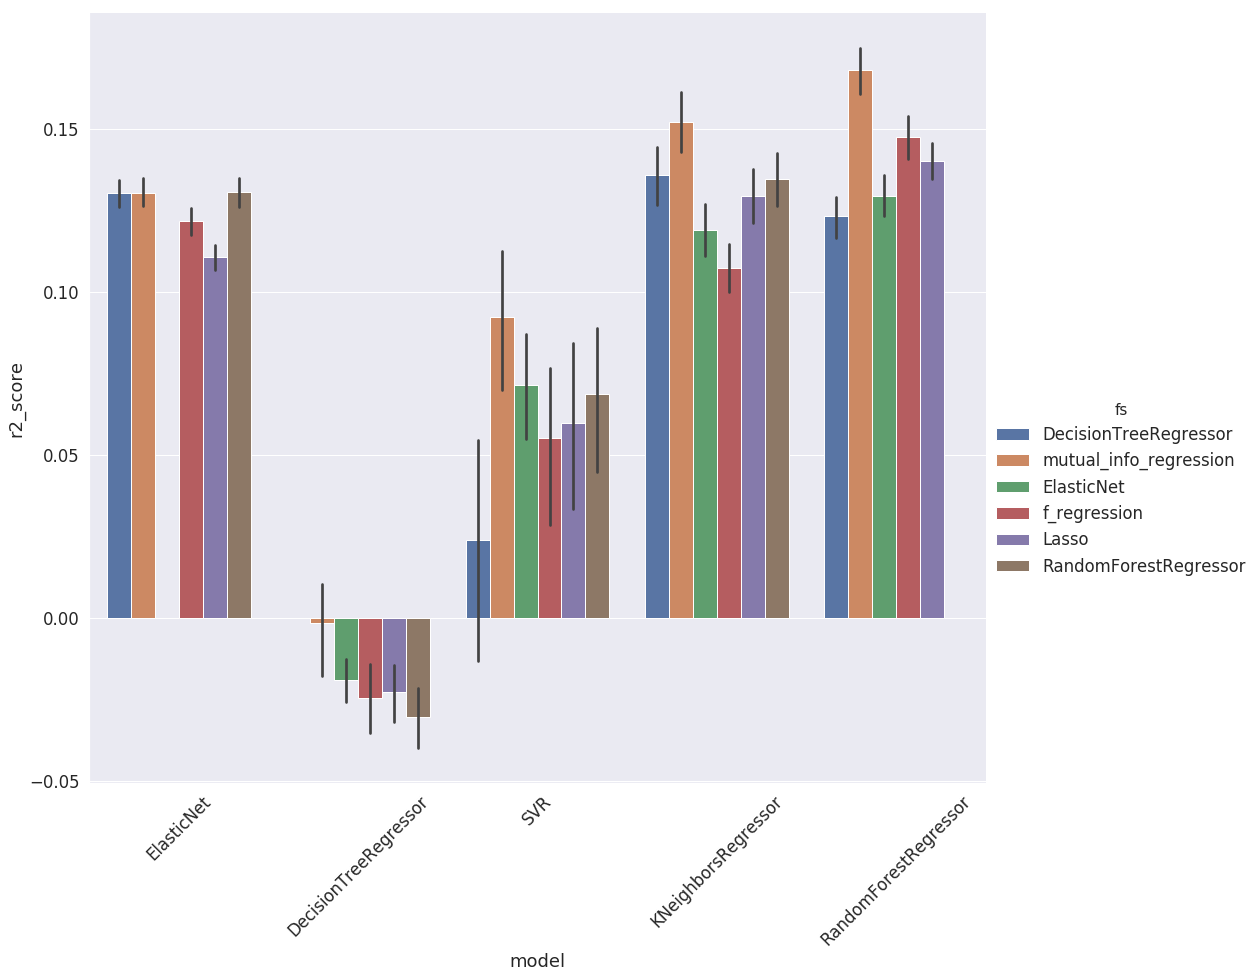

In [145]:
sns.set(font_scale=1.5)
g = sns.catplot(x = 'model', y='r2_score', hue='fs', data=clean, kind='bar', height=12, aspect=1.2, legend=True)
g.set_xticklabels(rotation=45)


#plt.savefig('fs and model.png')

# Influence of n on r2

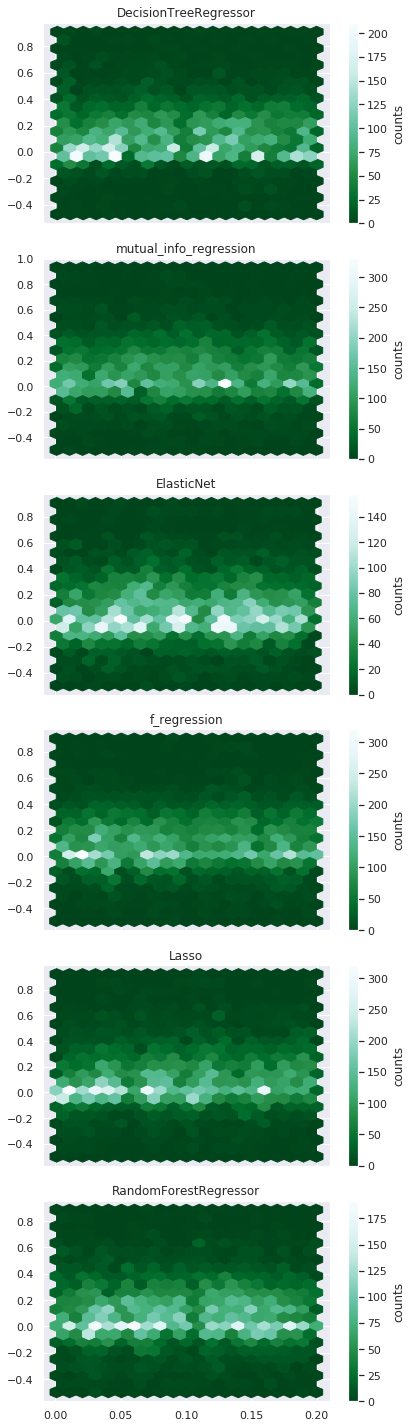

In [147]:
sns.set(font_scale=1)
lo = clean[clean['r2_score']>-0.5]
fig, ax = plt.subplots(6, 1, sharex=True,figsize=(6,20))
for i, ele in enumerate(lo['fs'].unique()):
    a = lo[lo['fs']==ele]
    hb = ax[i].hexbin(a['n'], a['r2_score'], gridsize=20, cmap=plt.cm.BuGn_r)
    cb = fig.colorbar(hb, ax=ax[i])
    cb.set_label('counts')
    ax[i].set_title(ele)
#cb = fig.colorbar(hb, ax=ax[4])
#cb.set_label('counts')
plt.tight_layout()

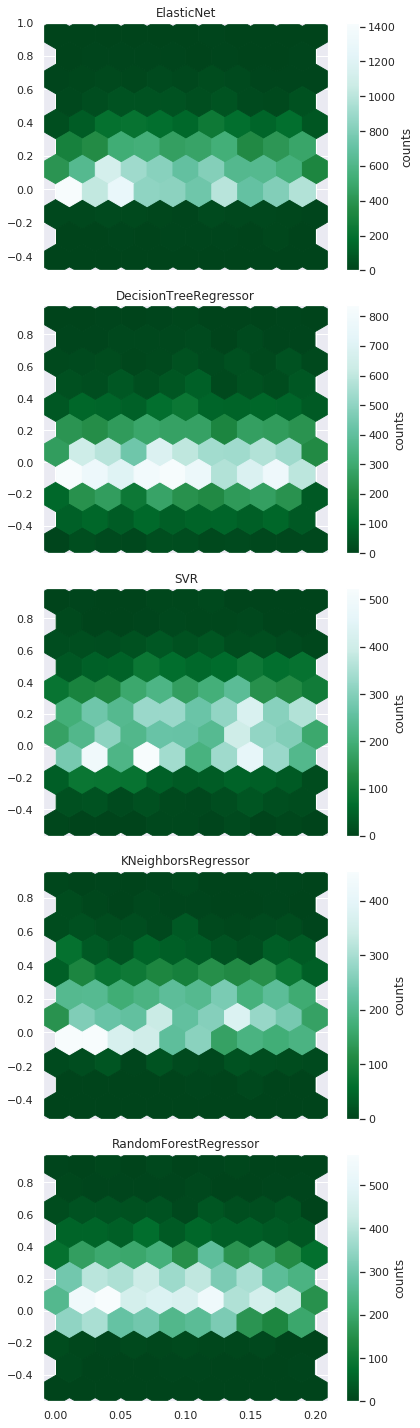

In [139]:
sns.set(font_scale=1)
lo = clean[clean['r2_score']>-0.5]
fig, ax = plt.subplots(5, 1, sharex=True,figsize=(6,20))
for i, ele in enumerate(lo['model'].unique()):
    a = lo[lo['model']==ele]
    hb = ax[i].hexbin(a['n'], a['r2_score'], gridsize=10, cmap=plt.cm.BuGn_r)
    cb = fig.colorbar(hb, ax=ax[i])
    cb.set_label('counts')
    ax[i].set_title(ele)
#cb = fig.colorbar(hb, ax=ax[4])
#cb.set_label('counts')
plt.tight_layout()

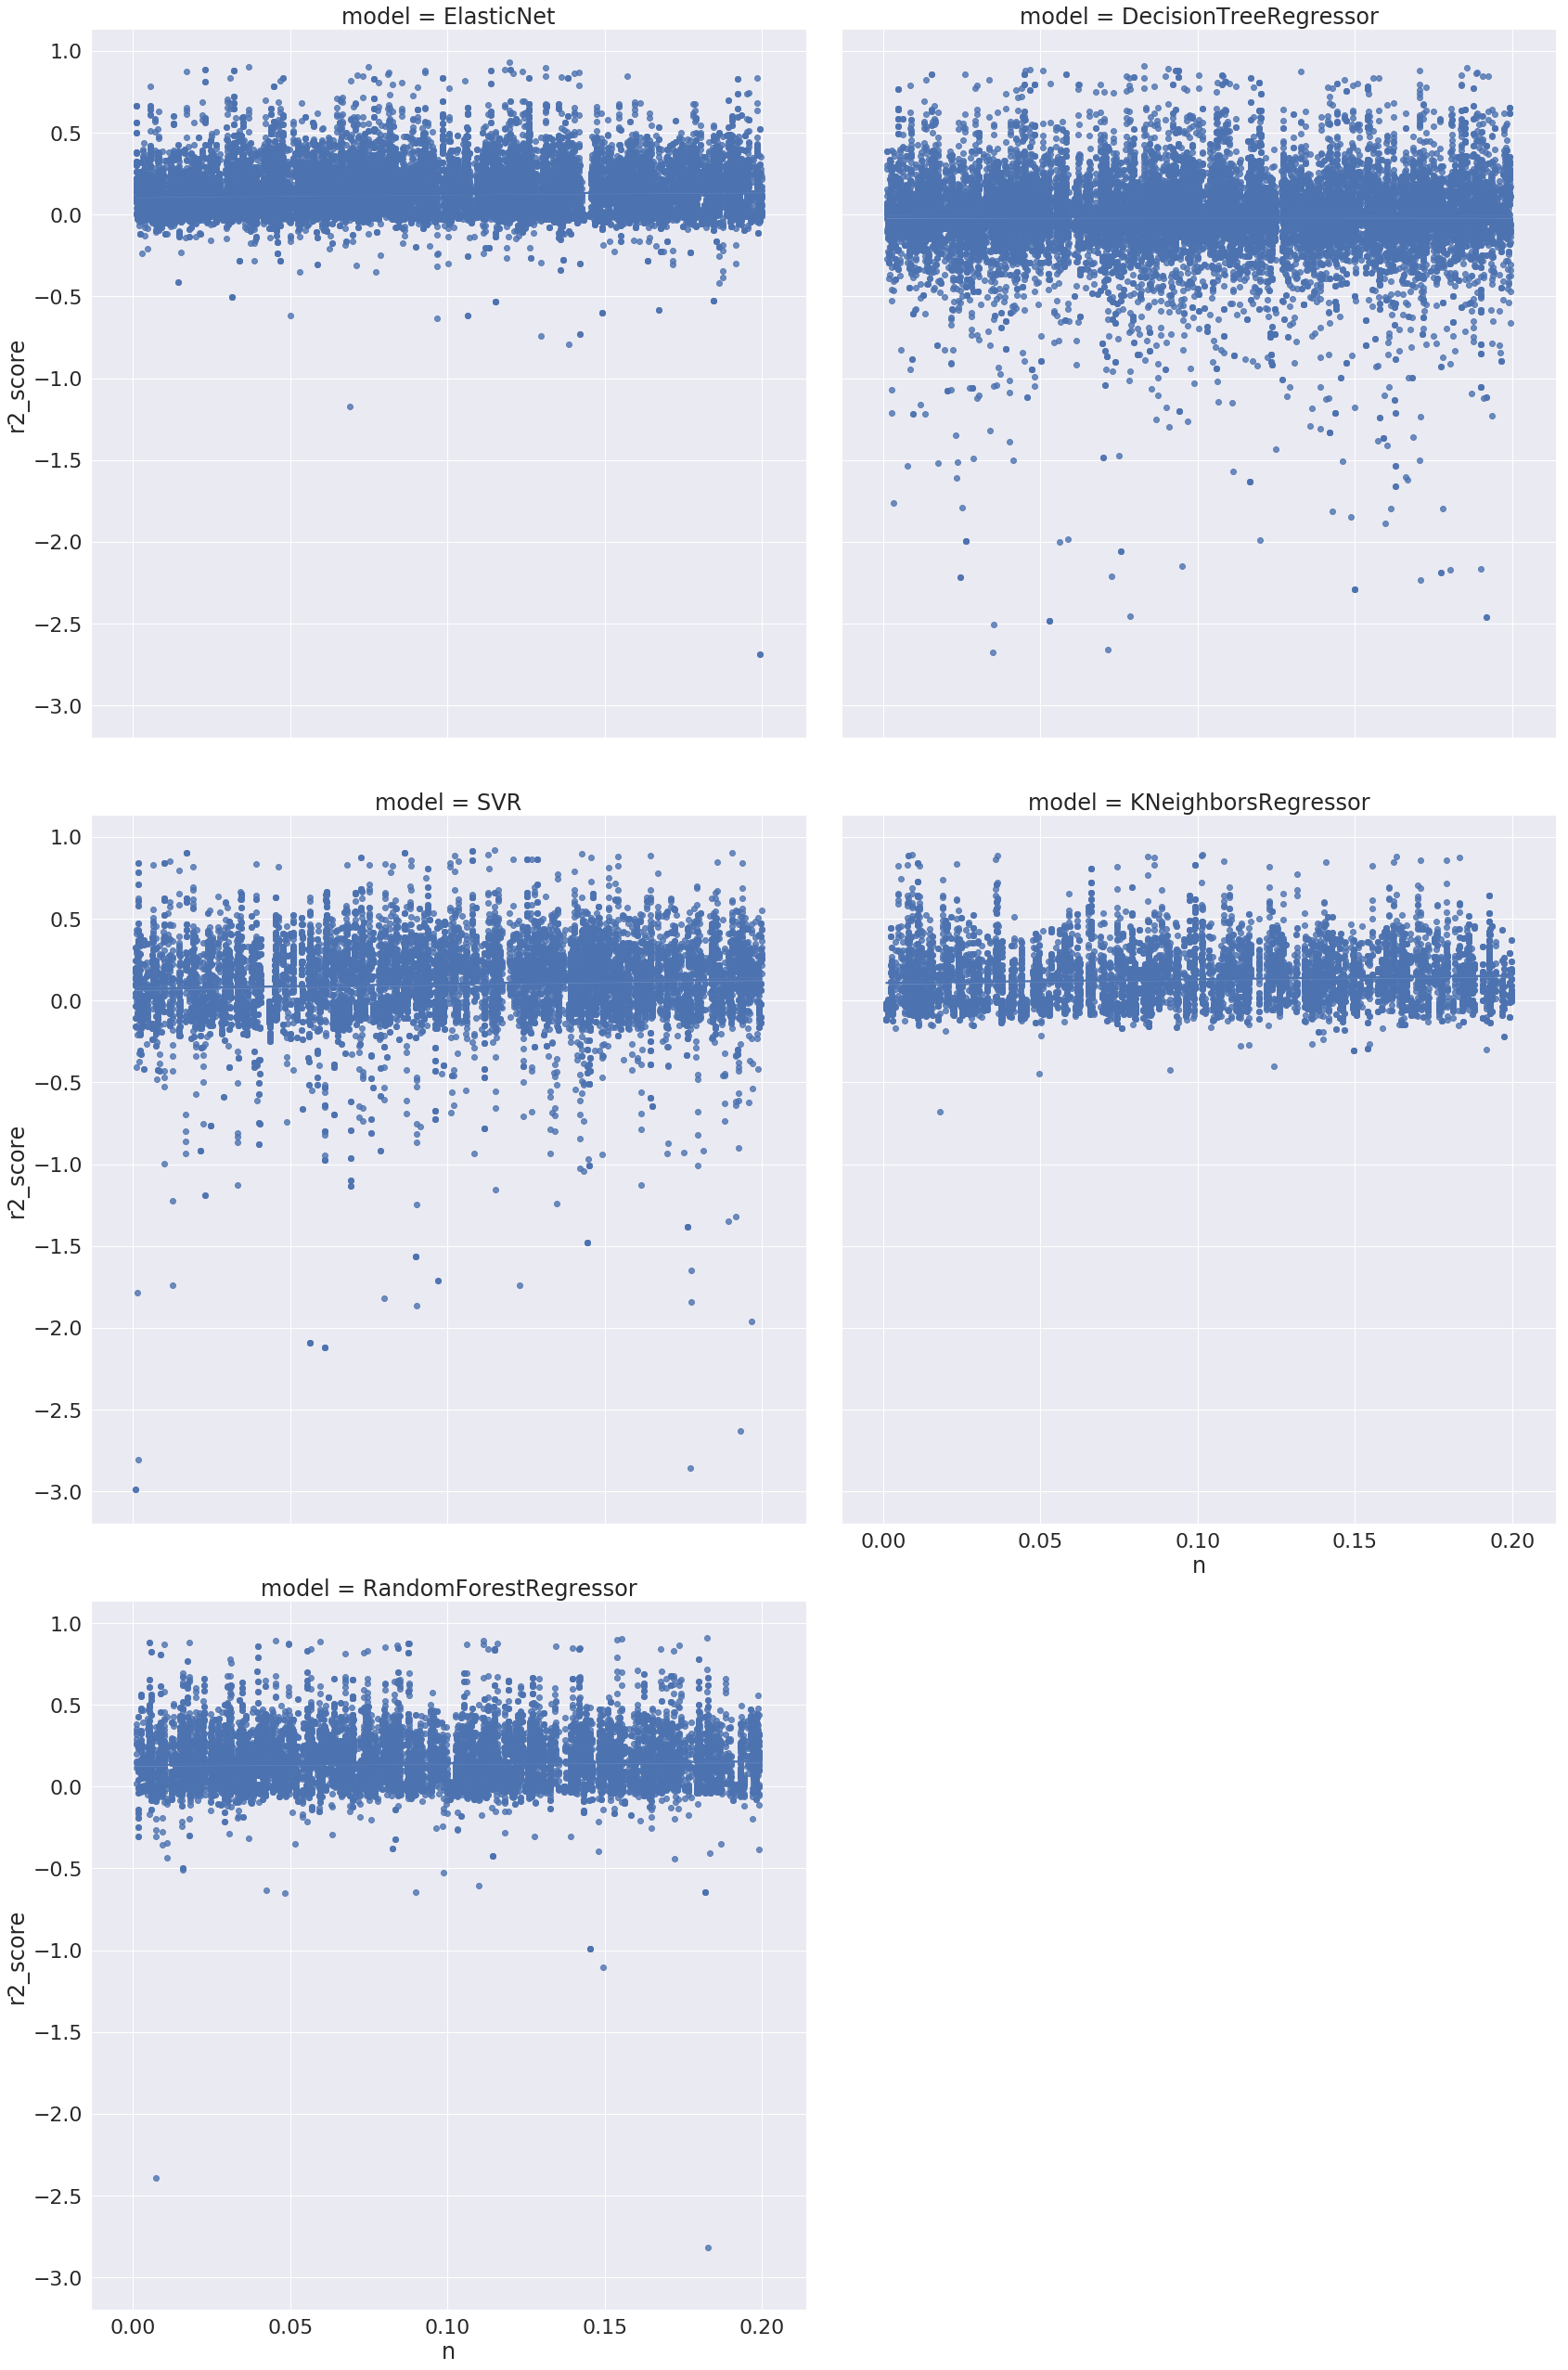

In [94]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=clean[clean['r2_score']>-3], col='model', col_wrap=2, fit_reg=True, height=12, legend=False)
#plt.savefig('model vs n.png')

In [ ]:
sns.set(font_scale=2)
g = sns.lmplot(x='n', y='r2_score', data=drugs, col='model', row='fs', fit_reg=True, height=12, legend=False)
#plt.savefig('model vs n.png')